# Problem
This notebook uses PyTorch to build and implement a Denoising Diffusion Probabilistic model (DDPM) to learn the distribution of sprites images and evaluate its generated images by using FID score.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.


# Setup

In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm, trange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image



## hyperparameters


In [ ]:
# diffusion hyperparameters
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = '/content/'

# training hyperparameters
batch_size = 100
n_epoch = 40
lrate=1e-3

## Sprites Dataset

In [ ]:
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy'
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprite_labels_nc_1788_16x16.npy'

--2025-01-04 12:51:14--  https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.23, 18.164.174.17, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/df/b9/dfb98dd9f5f7c221e653770544f82ac8de0044d1f52ab71a1e42ed1a332ae365/61cf3b7e3184f57f2bc2bf5e75fbcf08ba379241f58966c62a9716ef581b2916?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sprites_1788_16x16.npy%3B+filename%3D%22sprites_1788_16x16.npy%22%3B&Expires=1736254274&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNjI1NDI3NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2RmL2I5L2RmYjk4ZGQ5ZjVmN2MyMjFlNjUzNzcwNTQ0ZjgyYWM4ZGUwMDQ0ZDFmNTJhYjcxYTFlNDJlZDFhMzMyYWUzNjUvNjFjZjNiN2UzMTg0ZjU3ZjJiYz

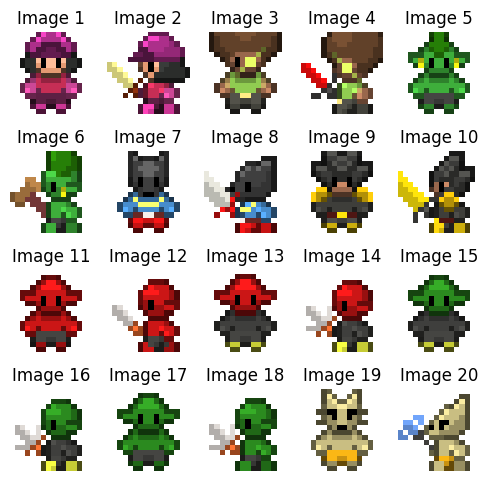

In [ ]:
sprites_samples = np.load("/content/sprites_1788_16x16.npy")[:20]
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
axes = axes.flatten()

# Loop through each image and plot it
for i in range(20):
    image = sprites_samples[i]

    # Plot the image in the appropriate subplot
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(f'Image {i + 1}')  # Set title

# Hide any unused subplots
for j in range(20, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, _sprites, _slabels, transform, null_context=False):
        self.transform = transform
        self.null_context = null_context
        self.sprites = _sprites
        self.slabels = _slabels
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]
])

In [ ]:
sprites = np.load("/content/sprites_1788_16x16.npy")
slabels = np.load("/content/sprite_labels_nc_1788_16x16.npy")

print(f"sprite shape: {sprites.shape}")
print(f"labels shape: {slabels.shape}")


train_sprites = sprites[:60000]
train_slabels = slabels[:60000]
val_sprites = sprites[60000:]
val_slabels = slabels[60000:]

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [ ]:
# load dataset
trian_dataset = CustomDataset(train_sprites, train_slabels, transform, null_context=False)
train_dataloader = DataLoader(trian_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# load dataset
val_dataset = CustomDataset(val_sprites, val_slabels, transform, null_context=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

## UNet

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

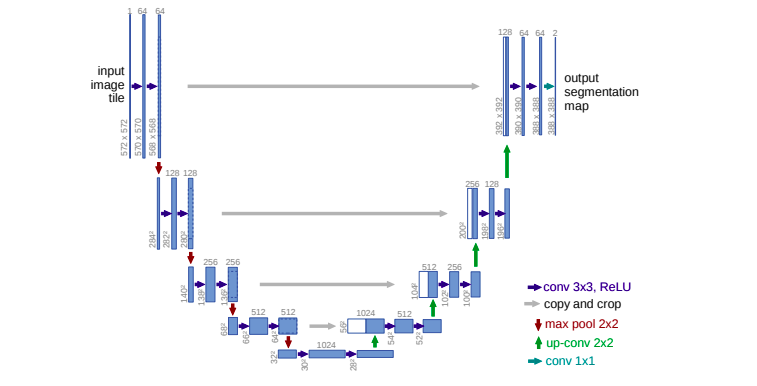

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization , segmentation and so on. These days, typical unet models incorporate ideas such as attention and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(Unet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## Training

In [ ]:
# construct model
nn_model = nn_model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [ ]:
#construct optimizer
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

We want to set up a "**variance schedule**" β, where $\beta_t$ specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. \\
At each time step t, the variance of the noise added to the previous step is predetermined by the variance schedule, and it's marked as $\beta_t$, where 0 < $\beta_1$ < $\beta_t$ < $\beta_2$ < 1.

In [ ]:
# Create Linear Scheduler - beta1 and beta2 are given in the hypermarapeters block
def create_linear_variance_schedule(timesteps, beta1, beta2):
    return np.linspace(beta1, beta2, timesteps, dtype=np.float32)


beta_schedule = create_linear_variance_schedule(timesteps, beta1, beta2)

### Forward

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample.

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


In [ ]:
# helper function: perturbs an image to a specified noise level
n_steps = 500
beta = torch.linspace(0.0001, 0.04, n_steps).to(device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(device)

def perturb_input(x0, t):
    """
    Perturbs an image to a specified noise level.

    Parameters:
        x0: Tensor - Original image tensor.
        t: Tensor or int - Timestep indicating noise level.

    Returns:
        Tensor: Perturbed image.
    """
    # noise = torch.randn_like(x0).to(x0.device)
    # return alpha_bar[t].sqrt()[t, None, None, None] * x0 + (1 - alpha_bar[t][t, None, None, None]) * noise, noise
    # sqrt_alpha_bar = alpha_bar[t].sqrt().view(-1, 1, 1, 1)
    # sqrt_one_minus_alpha_bar = (1 - alpha_bar[t]).sqrt().view(-1, 1, 1, 1)
    # noised_images = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
    # return noised_images, noise
    noise = torch.randn_like(x0).to(x0.device)  # Generate random noise
    sqrt_alpha_bar = alpha_bar.sqrt()[t, None, None, None]  # Use broadcast for alpha_bar^0.5
    sqrt_one_minus_alpha_bar = (1 - alpha_bar[t, None, None, None])  # Use broadcast for (1 - alpha_bar)
    noised_images = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise  # Perturb input with provided logic
    return noised_images, noise

### Train Diffsion

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

In [ ]:
def train_diffusion_model(model, optimizer, train_loader, val_loader, alpha_bar, epochs, device):
    train_losses, val_losses = [], []
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x0, _ in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            x0 = x0.to(device)
            t = torch.randint(0, n_steps, (x0.size(0),), device=device)
            noised_images, noise = perturb_input(x0, t)

            optimizer.zero_grad()
            predicted_noise = model(noised_images, t / n_steps)
            loss = criterion(predicted_noise, noise)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f'\nTrain Loss: {train_loss / len(train_loader)}')
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x0, _ in val_loader:
                x0 = x0.to(device)
                t = torch.randint(0, n_steps, (x0.size(0),), device=device)
                noised_images, noise = perturb_input(x0, t)
                predicted_noise = model(noised_images, t / n_steps)
                loss = criterion(predicted_noise, noise)
                val_loss += loss.item()
        print(f'Validation Loss: {val_loss / len(val_loader)}')
        val_losses.append(val_loss / len(val_loader))

    return train_losses, val_losses

In [ ]:
# TODO
# implement the training loop for diffusion model
train_losses, val_losses = train_diffusion_model(nn_model, optim, train_dataloader, val_dataloader, alpha_bar, n_epoch, device)

Epoch 1/40: 100%|██████████| 600/600 [00:23<00:00, 25.27it/s]


Train Loss: 0.2611376874645551


Validation Loss: 0.19847722262853668


Epoch 2/40: 100%|██████████| 600/600 [00:21<00:00, 28.51it/s]


Train Loss: 0.1792299013088147


Validation Loss: 0.1720640553655673


Epoch 3/40: 100%|██████████| 600/600 [00:21<00:00, 28.47it/s]


Train Loss: 0.15709308260430893


Validation Loss: 0.1602746930201443


Epoch 4/40: 100%|██████████| 600/600 [00:21<00:00, 27.54it/s]


Train Loss: 0.14625630910197893


Validation Loss: 0.14833161855737367


Epoch 5/40: 100%|██████████| 600/600 [00:21<00:00, 27.84it/s]


Train Loss: 0.1372823534657558


Validation Loss: 0.13890715305801152


Epoch 6/40: 100%|██████████| 600/600 [00:21<00:00, 27.69it/s]


Train Loss: 0.13287707044432562


Validation Loss: 0.13796028137511138


Epoch 7/40: 100%|██████████| 600/600 [00:21<00:00, 27.87it/s]


Train Loss: 0.12868140639116366


Validation Loss: 0.12840464325989184


Epoch 8/40: 100%|██████████| 600/600 [00:21<00:00, 27.60it/s]


Train Loss: 0.12517699697365364


Validation Loss: 0.12699037678793174


Epoch 9/40: 100%|██████████| 600/600 [00:22<00:00, 27.13it/s]


Train Loss: 0.12062710538506508


Validation Loss: 0.12370182259553143


Epoch 10/40: 100%|██████████| 600/600 [00:21<00:00, 27.29it/s]


Train Loss: 0.11769474409520626


Validation Loss: 0.11984982888917534


Epoch 11/40: 100%|██████████| 600/600 [00:21<00:00, 27.62it/s]


Train Loss: 0.11629818733781576


Validation Loss: 0.11621452964284792


Epoch 12/40: 100%|██████████| 600/600 [00:21<00:00, 27.96it/s]


Train Loss: 0.11279100331788262


Validation Loss: 0.1164946156192799


Epoch 13/40: 100%|██████████| 600/600 [00:21<00:00, 27.46it/s]


Train Loss: 0.11110292118042707


Validation Loss: 0.1157403490727856


Epoch 14/40: 100%|██████████| 600/600 [00:21<00:00, 27.43it/s]


Train Loss: 0.10849436741943161


Validation Loss: 0.11156664160238643


Epoch 15/40: 100%|██████████| 600/600 [00:21<00:00, 27.40it/s]


Train Loss: 0.10811195019011696


Validation Loss: 0.10923294219993004


Epoch 16/40: 100%|██████████| 600/600 [00:21<00:00, 28.21it/s]


Train Loss: 0.10669732523461183


Validation Loss: 0.10857213464673279


Epoch 17/40: 100%|██████████| 600/600 [00:21<00:00, 27.51it/s]


Train Loss: 0.10468476015453537


Validation Loss: 0.10775374782075282


Epoch 18/40: 100%|██████████| 600/600 [00:21<00:00, 27.53it/s]


Train Loss: 0.10337345795085033


Validation Loss: 0.10279546623580715


Epoch 19/40: 100%|██████████| 600/600 [00:21<00:00, 27.66it/s]


Train Loss: 0.09988802457228303


Validation Loss: 0.10543529729859359


Epoch 20/40: 100%|██████████| 600/600 [00:21<00:00, 28.07it/s]


Train Loss: 0.09963121442745129


Validation Loss: 0.10231764589239951


Epoch 21/40: 100%|██████████| 600/600 [00:21<00:00, 27.79it/s]


Train Loss: 0.09885895053545633


Validation Loss: 0.10513481861423879


Epoch 22/40: 100%|██████████| 600/600 [00:21<00:00, 27.48it/s]


Train Loss: 0.09899250607316692


Validation Loss: 0.10063608796620856


Epoch 23/40: 100%|██████████| 600/600 [00:21<00:00, 27.42it/s]


Train Loss: 0.09609667889152963


Validation Loss: 0.09911693747909296


Epoch 24/40: 100%|██████████| 600/600 [00:21<00:00, 27.43it/s]


Train Loss: 0.09595345145091415


Validation Loss: 0.09754334553620037


Epoch 25/40: 100%|██████████| 600/600 [00:21<00:00, 28.24it/s]


Train Loss: 0.09622990986332297


Validation Loss: 0.09723087480025631


Epoch 26/40: 100%|██████████| 600/600 [00:21<00:00, 27.52it/s]


Train Loss: 0.09410157725214958


Validation Loss: 0.09721443771707769


Epoch 27/40: 100%|██████████| 600/600 [00:21<00:00, 27.48it/s]


Train Loss: 0.09465548198049267


Validation Loss: 0.0919128940472392


Epoch 28/40: 100%|██████████| 600/600 [00:21<00:00, 27.44it/s]


Train Loss: 0.09311766412730019


Validation Loss: 0.09057832397773963


Epoch 29/40: 100%|██████████| 600/600 [00:21<00:00, 28.29it/s]


Train Loss: 0.09153529264653723


Validation Loss: 0.09213372526474956


Epoch 30/40: 100%|██████████| 600/600 [00:21<00:00, 27.61it/s]


Train Loss: 0.0907555497996509


Validation Loss: 0.09185426231144236


Epoch 31/40: 100%|██████████| 600/600 [00:21<00:00, 27.57it/s]


Train Loss: 0.09088808681815863


Validation Loss: 0.09314545535412776


Epoch 32/40: 100%|██████████| 600/600 [00:21<00:00, 27.38it/s]


Train Loss: 0.09004433690259854


Validation Loss: 0.089345977964754


Epoch 33/40: 100%|██████████| 600/600 [00:21<00:00, 27.68it/s]


Train Loss: 0.09028083564713597


Validation Loss: 0.08943629475171064


Epoch 34/40: 100%|██████████| 600/600 [00:21<00:00, 28.06it/s]


Train Loss: 0.08873019121587276


Validation Loss: 0.08943487727875207


Epoch 35/40: 100%|██████████| 600/600 [00:21<00:00, 27.44it/s]


Train Loss: 0.0893561462375025


Validation Loss: 0.08777818768000116


Epoch 36/40: 100%|██████████| 600/600 [00:21<00:00, 27.45it/s]


Train Loss: 0.08771820748845736


Validation Loss: 0.08764500962887085


Epoch 37/40: 100%|██████████| 600/600 [00:21<00:00, 27.37it/s]


Train Loss: 0.08715274533256888


Validation Loss: 0.08681839652562222


Epoch 38/40: 100%|██████████| 600/600 [00:21<00:00, 27.88it/s]


Train Loss: 0.08526977530991038


Validation Loss: 0.08871274999007076


Epoch 39/40: 100%|██████████| 600/600 [00:22<00:00, 27.09it/s]


Train Loss: 0.08626138283560673


Validation Loss: 0.08387712944222957


Epoch 40/40: 100%|██████████| 600/600 [00:22<00:00, 27.08it/s]


Train Loss: 0.08488934515664975


Validation Loss: 0.08559316359967196


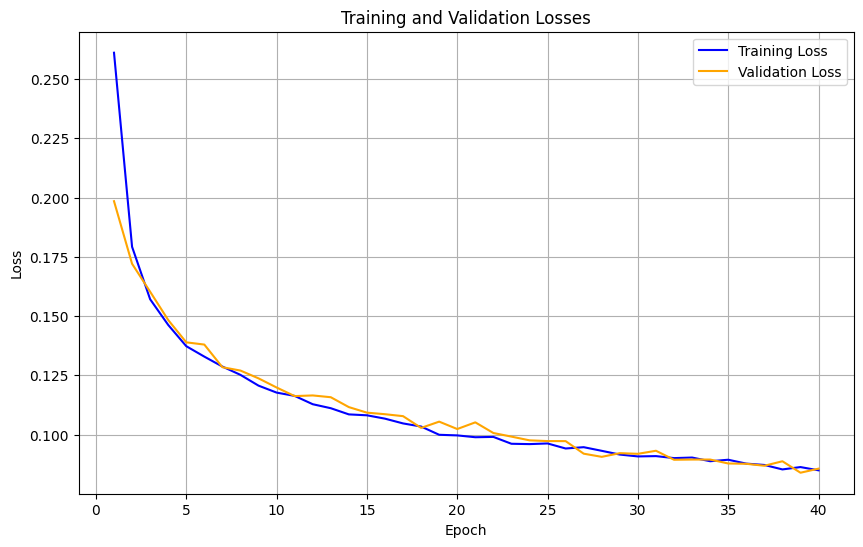

In [ ]:
epochs = list(range(1, len(val_losses) + 1))
# plot loss value for each epoch for train dataset and validation
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Training Loss", color="blue")
plt.plot(epochs, val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.grid()
plt.show()

## Reverse process: DDPM Sampling

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that looks like a real image. \\
Below image show the sampling algorithm

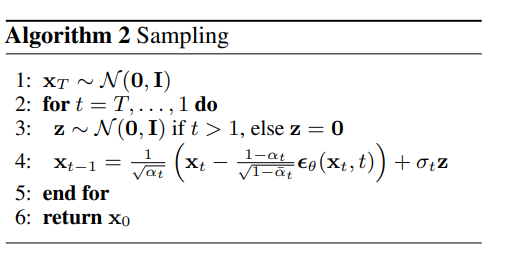

In [ ]:
def p_xt_ddpm(current_noise_image, predicted_noise, time_step, alpha_bar):
    # implement the denoising step for generating x_(t-1) from x_t in this function
    z = torch.randn_like(current_noise_image)
    noise = beta.sqrt()[time_step] * z
    mean = (current_noise_image - predicted_noise * ((1 - alpha[time_step]) / (1 - alpha_bar[time_step]).sqrt())) / alpha[time_step].sqrt()
    return mean + noise

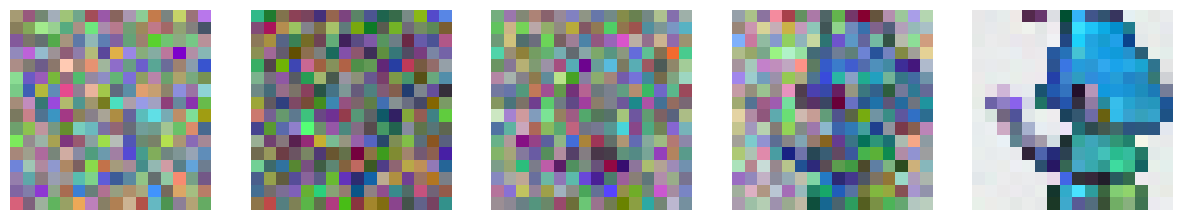

In [ ]:
# Implement the generation function and plot the samples of reverse process for different time steps
import torchvision.transforms as T

def generate_images(model, n_samples, reverse_fn, alpha_bar, method="ddpm"):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for i in range(n_samples):
            x_t = torch.randn((1, 3, height, height), device=device)
            images = []

            with torch.no_grad():
                for t in reversed(range(1, n_steps)):
                    pred_noise = model(x_t, torch.tensor([t], device=device) / n_steps)
                    x_t = reverse_fn(x_t, pred_noise, t, alpha_bar)
                    if t % (n_steps // 5) == 0 or t == 1:
                      images.append((x_t - x_t.min()) / (x_t.max() - x_t.min()).cpu().clone())


            fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
            transform = T.ToPILImage()
            for j, img in enumerate(images):
                axs[j].imshow(transform(img.squeeze(0)))
                axs[j].axis('off')
            plt.show()

generate_images(nn_model, 1, p_xt_ddpm, alpha_bar, method="ddpm")

## Reverse process: DDIM Sampling

Study the DDIM sampling method for reverse process and like the previous part, Implement this process regarding the DDIM method.

In [ ]:
def p_xt_ddim(current_noise_image, predicted_noise, time_step, alpha_bar, eta=0.1):
    # Implement the denoising step for generating x_(t-1) from x_t in this function
    z = torch.randn_like(current_noise_image)
    # noise = eta * beta.sqrt()[time_step] * z
    pred_x0 = (current_noise_image - predicted_noise * (1 - alpha_bar[time_step]).sqrt()) / alpha_bar[time_step].sqrt()
    c1 = eta * ((1 - alpha_bar[time_step] / alpha_bar[time_step - 1]) * (1 - alpha_bar[time_step - 1]) / (
                    1 - alpha_bar[time_step])).sqrt()
    c2 = ((1 - alpha_bar[time_step - 1]) - c1 ** 2).sqrt()
    x_i = alpha_bar[time_step - 1].sqrt() * pred_x0 + c1 * z + c2 * predicted_noise
    return x_i



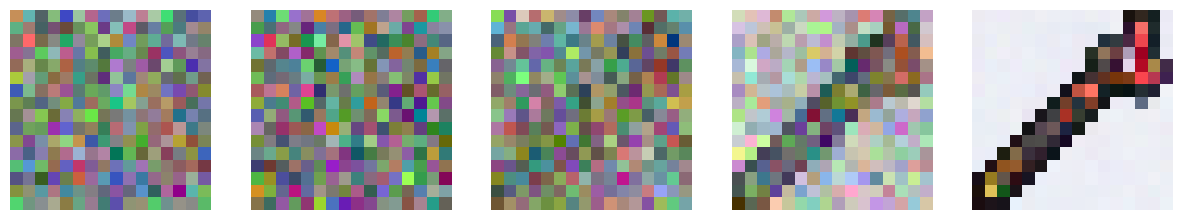

In [ ]:
# Implement the generation function and plot the samples of reverse process for different time steps
generate_images(nn_model, 1, p_xt_ddpm, alpha_bar, method="ddim")

## Results

Plot 20 generated images by each of generation processes implemented in the previous part

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
def plot_generated_images(model, reverse_fn, alpha, alpha_bar, beta, method="ddpm", num_images=20):

    model.eval()
    x_t = torch.randn((num_images, 3, height, height), device=device)

    with torch.no_grad():
        for t in reversed(range(1, n_steps)):
            pred_noise = model(x_t, torch.tensor([t], device=device) / n_steps)
            x_t = reverse_fn(x_t, pred_noise, t, alpha_bar)


    x_t = (x_t - x_t.min()) / (x_t.max() - x_t.min())

    grid = make_grid(x_t.cpu(), nrow=5, normalize=True)  # Create grid
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"Generated Images using {method.upper()}")
    plt.axis("off")
    plt.show()


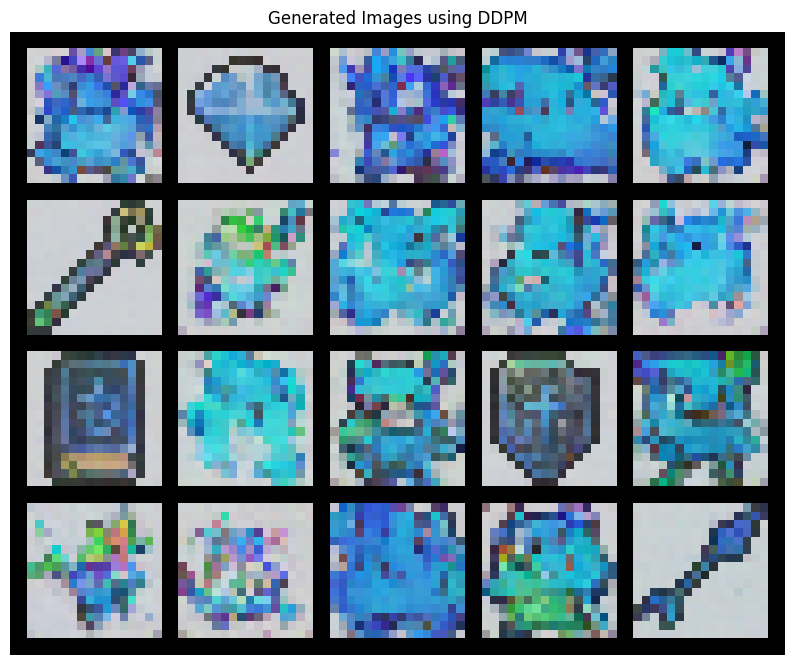

In [ ]:
# implement 20 images generated by DDPM sampling method
plot_generated_images(nn_model, p_xt_ddpm, alpha, alpha_bar, beta, method="ddpm", num_images=20)

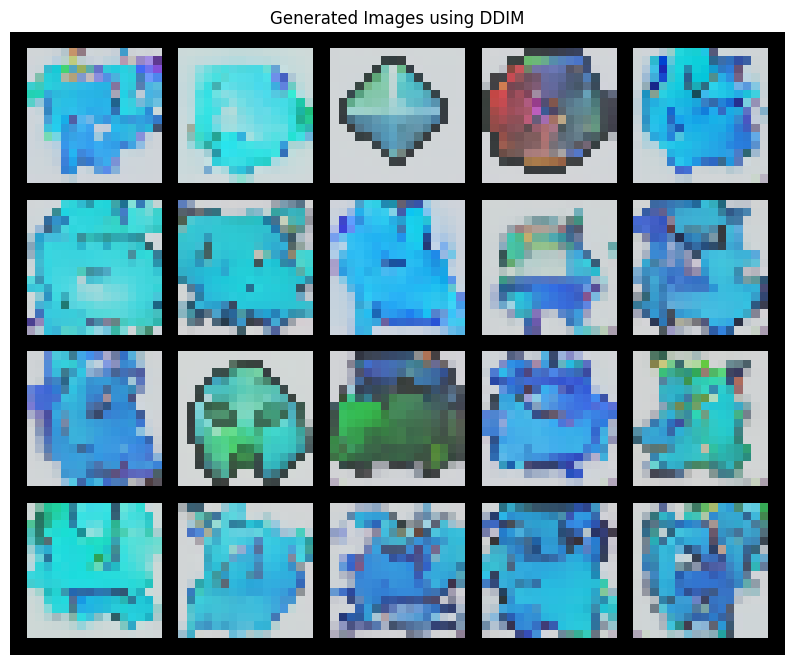

In [ ]:
# implement 20 images generated by DDIM sampling method
plot_generated_images(nn_model, p_xt_ddim, alpha, alpha_bar, beta, method="ddim", num_images=20)

# Evaluating the Generated Samples:

Now we want to evaluate our model. For this, we use the FID score.

First, read [this link](https://github.com/mseitzer/pytorch-fid) to become familiar with this metric and its usage.

Installation

In [ ]:
!pip install -qq pytorch-fid

Generate 3000 images by your model (by using either of generation processes) and save them in a directory. Also, save 3000 images from the sprites dataset and save them in another directory.

In [ ]:
# save generated images and real images
def save_generated_images(model, num_images, reverse_fn, alpha_bar, save_dir, method="ddpm"):
    import os

    model.eval()
    x_t = torch.randn((num_images, 3, height, height), device=device)

    with torch.no_grad():
        for t in reversed(range(1, n_steps)):
            pred_noise = model(x_t, torch.tensor([t], device=device) / n_steps)
            x_t = reverse_fn(x_t, pred_noise, t, alpha_bar)

    x_t = (x_t - x_t.min()) / (x_t.max() - x_t.min())

    os.makedirs(save_dir, exist_ok=True)

    for i, img in enumerate(x_t):
        img = img.cpu().permute(1, 2, 0).numpy()
        plt.imsave(os.path.join(save_dir, f"{method}_sample_{i}.png"), img)


save_generated_images(nn_model, 3000, p_xt_ddpm, alpha_bar, "/content/generated_images", method="ddpm")
save_generated_images(nn_model, 3000, p_xt_ddim, alpha_bar, "/content/generated_images_ddim", method="ddim")

In [ ]:
real_dir = "/content/real_images"
os.makedirs(real_dir, exist_ok=True)
for i, img in enumerate(train_sprites[:3000]):
    img = torch.tensor(img).cpu().numpy()
    plt.imsave(os.path.join(real_dir, f"real_{i}.png"), img)

In [ ]:
# 1- Directory of the original images.
# 2- Directory of the generated images (the directory that you created in the last code cell)
from pytorch_fid import fid_score

def compute_fid(real_dir, generated_dir):
    return fid_score.calculate_fid_given_paths([real_dir, generated_dir], batch_size=50, device=device, dims=2048)


fid_ddpm = compute_fid(real_dir, "/content/generated_images")
print(f"FID Score for DDPM: {fid_ddpm}")

fid_ddim = compute_fid(real_dir, "/content/generated_images_ddim")
print(f"FID Score for DDIM: {fid_ddim}")

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 129MB/s]
100%|██████████| 60/60 [00:12<00:00,  4.98it/s]


FID Score for DDPM: 98.180702234958


100%|██████████| 60/60 [00:12<00:00,  4.91it/s]


FID Score for DDIM: 103.88677154681972
